In [156]:
import numpy as np
import polytope as pc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict

import time
import sys
sys.path.append('../')

from best.mdp import MDP, ParallelMDP
from best.ltl import solve_ltl_cosafe
from best.abstraction import Abstraction

ROVER_STEPS = 15   # rover num of steps
COPTER_STEPS = 30  # copter num of steps
rover_init = [0, -4.5]
copter_init = [-1, -4.5, 2]

###### ROVER MODEL (deterministic for now..) ######
rover_abs = Abstraction([-5, -5], [5, 5], [10, 10])
rover = rover_abs.mdp

print rover

MDP: 5 inputs "a" --> 100 outputs "xc"


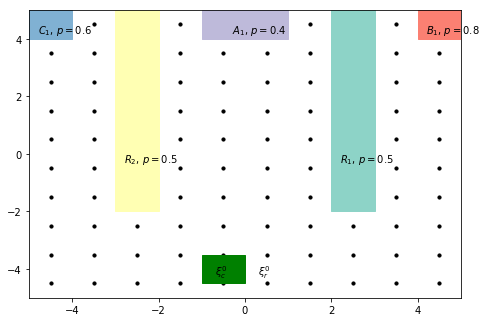

In [157]:
from matplotlib2tikz import save as tikz_save

# Define regions
regs = OrderedDict()

regs['r1'] = (pc.box2poly(np.array([[2, 3], [-2, 5]])), 0.5)
regs['r2'] = (pc.box2poly(np.array([[-3, -2], [-2, 5]])), 0.5)
regs['a1'] = (pc.box2poly(np.array([[-1, 1], [4, 5]])), 0.4)
regs['b1'] = (pc.box2poly(np.array([[4, 5], [4, 5]])), 0.8)
regs['c1'] = (pc.box2poly(np.array([[-5, -4], [4, 5]])), 0.6)

pinit = [2, 2, 2, 2, 2]

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abs.plot(ax)
              
def plot_region(poly, prob, color, name):
    ax.add_patch(patches.Polygon(pc.extreme(poly), color=color))
    _, xc = pc.cheby_ball(poly)
    ax.text(xc[0]-0.3, xc[1]-0.3, '${}_{}$, $p={}$'.format(name[0].upper(), name[1], prob))
                
cm = plt.get_cmap('Set3')

i = 0
for (name, info) in regs.iteritems():
    plot_region(info[0], info[1], cm(i), name)
    i += 1

ax.text(rover_init[0]+0.3, rover_init[1]+0.3, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle( copter_init[:2], 1, 1, color='green' ))
ax.text(copter_init[0]+0.3, copter_init[1]+0.3, '$\\xi_c^0$')

fig.savefig('exp1-map.pdf')


In [158]:
## Environment belief model

def get_mdp(p0, qw, name):
    # Create map belief MDP with prior p0 and qw quality of weak measurements
    if p0 == 0:
        # no dynamics
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 0
    
    elif p0 == 1:
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 1
        
    else:
        pm = p0/2
        pp = p0 + (1-p0)/2
        # levels [0 p- p0 p+ 1]

        Tnone = np.eye(5);
        Tweak = np.array([[1,           0,             0,       0,              0], 
                          [qw*(1-pm),   (1-qw)*(1-pm), 0,       (1-qw)*pm,      qw*pm],
                          [qw*(1-p0),   (1-qw)*p0,     0,       (1-qw)*(1-p0),  qw*p0],
                          [qw*(1-pp),   (1-qw)*(1-pp), 0,       (1-qw)*pp,      qw*pp],
                          [0,           0,             0,       0,              1]])
        Tstrong = np.array([[1,      0, 0, 0, 0],
                            [(1-pm), 0, 0, 0, pm],
                            [(1-p0), 0, 0, 0, p0],
                            [(1-pp), 0, 0, 0, pp],
                            [0,      0, 0, 0, 1]])

        def output_fcn(s):
            return [0, pm, p0, pp, 1][s]
    
    return MDP([Tnone, Tweak, Tstrong], input_name=name+'_u', output_name=name+'_b', output_fcn=output_fcn)

env = ParallelMDP([get_mdp(info[1], 0.1, name) for (name, info) in regs.iteritems()])

print env

MDP: 243 inputs "(r1_u, r2_u, a1_u, b1_u, c1_u)" --> 3125 outputs "(r1_b, r2_b, a1_b, b1_b, c1_b)"


In [159]:
## Connect Rover-env
def connection(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        poly = info[0]
        if np.all(poly.A.dot(xr) < poly.b + 2):
            ret[i] = 2    # strong measurement
        i += 1
    return set([tuple(ret)])

print connection([-3.5, 3.5])
print connection([0, 3.5])
print connection([3.5, 3.5])
print connection([0, -4])

prod_mdp = rover.product(env, connection=connection)
print prod_mdp

set([(0, 2, 0, 0, 2)])
set([(0, 0, 2, 0, 0)])
set([(2, 0, 0, 2, 0)])
set([(0, 0, 0, 0, 0)])
MDP: 5 inputs "a" --> 312500 outputs "(xc, (r1_b, r2_b, a1_b, b1_b, c1_b))"


In [160]:
## Set up LTL problem

formula = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( emptyA & sample C ) )'

# map ((xc, ry), (e1, ..., en)) -> 2^2^{sampleA, sampleB, fail}
def ltl_connection(xc_env):
    xc = np.array(xc_env[0]).reshape(2,1)
    env = xc_env[1]
    
    i = 0
    
    ret = set([])
    
    for (name, info) in regs.iteritems():
        poly = info[0]
        
        if name[0] == 'r' and poly.contains(xc) and env[i] > 0:
            # we are in risk reg that is not confirmed safe 
            ret |= set(['fail'])
            
        if name[0] == 'a' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleA'])

        if name[0] == 'b' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleB'])

        if name[0] == 'c' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleC'])
        i += 1

    if env[2] == 0:
        # no sample A
        ret |= set(['emptyA'])

    return set([tuple(ret)])

print ltl_connection(((0,4.5), (0,0,1,0,0,0)))
print ltl_connection(((0,4.5), (0,0,0,0,0,0)))


print ltl_connection(((4.5,4.5), (0,0,0,1,0,0)))
print ltl_connection(((4.5,4.5), (0,0,0,0.5,0,0)))
print ltl_connection(((4.5,4.5), (0,0,1,0.5,0,0)))

print ltl_connection(((3,4), (0,0,0,0,0,0)))
print ltl_connection(((3,4), (0.3,0,0,0,0,0)))

set([('sampleA',)])
set([('emptyA',)])
set([('emptyA', 'sampleB')])
set([('emptyA',)])
set([()])
set([('emptyA',)])
set([('fail', 'emptyA')])


In [161]:
pol = solve_ltl_cosafe(prod_mdp, formula, ltl_connection, delta=0.01, maxiter=ROVER_STEPS, verbose=True)

iteration 0, time 0.00734519958496
iteration 1, time 11.2209870815
iteration 2, time 20.4075961113
iteration 3, time 29.6011559963
iteration 4, time 38.7781422138
iteration 5, time 48.2281022072
iteration 6, time 59.4988582134
iteration 7, time 70.8128190041
iteration 8, time 81.792840004
iteration 9, time 91.6814980507
iteration 10, time 101.797489166
iteration 11, time 111.050379992
iteration 12, time 120.68900609
iteration 13, time 130.161900997
iteration 14, time 140.140111208
finished after 152.962571144s and 15 iterations


success probability: 0.1088


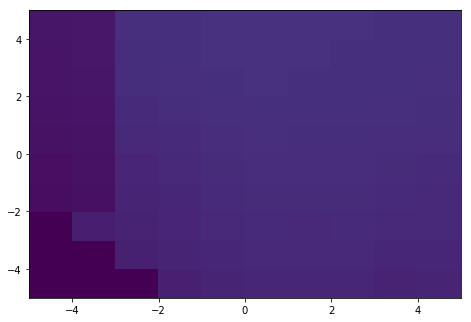

In [162]:
cm = plt.get_cmap('winter')
    
def my_value(x, mapstate):    
    s_abstr = rover_abs.x_to_s(np.array(x).flatten())
    s_tot = prod_mdp.global_state( (s_abstr, mapstate) )

    _, val = pol.get_input(s_tot)
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), pinit)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print 'success probability: {}'.format(my_value(rover_init, pinit))

fig.savefig('value-rov.pdf')

In [163]:
# Copter system

copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2])

copter = copter_abstr.mdp

print copter

MDP: 7 inputs "a" --> 200 outputs "xc"


In [210]:
# connect copter with map
def is_above(poly, x):
    # return true x within distance 1 of func
    return poly.contains(x.reshape((2,1)))

def is_adjacent(poly, x):
    # return true x within distance 1 of func
    return np.all(poly.A.dot(x) < poly.b + 3)

def copt_env(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        if is_above(info[0], xr[0:2]) and xr[2] < 2.5:
            ret[i] = 2    # strong measurement
        elif is_adjacent(info[0], xr[0:2]) and xr[2] > 2.5:
            ret[i] = 1    # weak measurement
        i += 1
        
    return set([tuple(ret)])

print copt_env(np.array([4.5, 4.5, 2]))
print copt_env(np.array([4.5, 4.5, 3]))
print copt_env(np.array([-4.5, 4.5, 3]))
print copt_env(np.array([0, 4.5, 2]))

mdp_copt_env = copter.product(env, connection=copt_env)
print mdp_copt_env

set([(0, 0, 0, 2, 0)])
set([(1, 0, 0, 1, 0)])
set([(0, 1, 0, 0, 1)])
set([(0, 0, 2, 0, 0)])
MDP: 7 inputs "a" --> 625000 outputs "(xc, (r1_b, r2_b, a1_b, b1_b, c1_b))"


In [204]:
# value function at time t: rover success entropy * copter safe
VT = np.zeros(mdp_copt_env.N_list)
for n in range(copter.N):
    if n == copter_abstr.x_to_s(np.array(copter_init)):   # if safe
        for m in range(env.N):
            maps = env.local_states(m)
            if my_value( rover_init, maps ) > 0:
                v = my_value( rover_init, maps )
#                 VT[n, m] = v
                VT[n, m] = np.abs(v - 0.5)
#                 VT[n, m] = 1 + v * np.log2(v) + (1-v) * np.log2(1-v)
            
# run value iteration
Vt_list = [VT]

t0 = time.time()
for step in range(COPTER_STEPS):
    print 'step {}, time {}'.format(step, time.time()-t0)

    W_m = mdp_copt_env.sequential_bellman(Vt_list[-1])
    
    Vt_list.append(W_m.max(axis=0))

step 0, time 0.000117063522339
step 1, time 3.13457298279
step 2, time 6.20673298836
step 3, time 9.31045389175
step 4, time 12.3829140663
step 5, time 15.415899992
step 6, time 18.4643440247
step 7, time 21.5158948898
step 8, time 24.5716440678
step 9, time 27.629981041
step 10, time 30.6761250496
step 11, time 33.75958395
step 12, time 36.8307390213
step 13, time 39.9027309418
step 14, time 42.970872879
step 15, time 46.0469419956
step 16, time 49.0957598686
step 17, time 52.1628499031
step 18, time 55.2434709072
step 19, time 58.3155639172
step 20, time 61.3824250698
step 21, time 64.453469038
step 22, time 67.5271849632
step 23, time 70.6120269299
step 24, time 73.6802389622
step 25, time 76.7473340034
step 26, time 79.8744580746
step 27, time 82.9516010284
step 28, time 86.0539429188
step 29, time 89.1371870041


success value: 0.420085012819


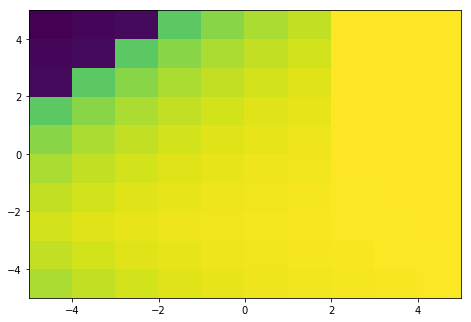

In [208]:
cm = plt.get_cmap('winter')
    
def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    
    nmap = env.global_state(mapstate)

    return Vt_list[-1][scop, nmap]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), pinit)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print 'success value: {}'.format(copter_value(np.array(copter_init), pinit))

plt.savefig('value-cop.pdf')

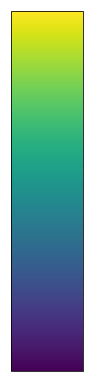

In [146]:
import matplotlib

fig = plt.figure(figsize=(1,5))
ax = plt.Axes(fig, [0.,0.,1.,1.])
ax.set_axis_off()

fig.add_axes(ax)

cb1 = matplotlib.colorbar.ColorbarBase(ax)

fig.savefig('cbar.pdf')